# General setup

In [1]:
import os, sys
import time
import itertools

import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import h5py

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


# Basic utilities

In [13]:
start_time = None

def start_timer():
    global start_time
    if device == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print():
    if device == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    print("\nTotal execution time {:.3f} sec".format(end_time - start_time))

In [11]:
def plot_images(img_list, num=6, size=12):
    if isinstance(img_list, tuple):
        img_list = list(img_list)
    elif isinstance(img_list, (np.ndarray, torch.Tensor)):
        img_list = [img_list]
    else:
        raise Exception("input must be ndarray or sequence or list of ndarrays")
        
    for i in range(len(img_list)):
        if isinstance(img_list[i], torch.Tensor):
            img_list[i] = img_list[i].cpu().numpy()
            
        depth = img_list[i].ndim
        if depth == 4:
            continue
        elif depth == 3:
            img_list[i] = np.expand_dims(img_list[i], 0)
        elif depth == 2:
            img_list[i] = np.expand_dims(img_list[i], (0,1))
        else:
            raise Exception("image arrays must have depth between 2 and 4, inclusive")
            
    lengths = [imgs.shape[0] for imgs in img_list]
    if lengths.count(lengths[0]) != len(lengths):
        raise Exception("image arrays must have the same first dimension size")
    if num == -1 or num > lengths[0]:
        num = lengths[0]
    num_list = len(img_list)
    
    if num == 1:
        plt.figure(figsize=(size, size/num_list))
        for i, img in enumerate(img_list):
            plt.subplot(1, num_list, i+1)
            plt.imshow(img[0, 0], cmap='gray_r')
            plt.axis('off')
    else:
        plt.figure(figsize=(size, size*num_list/num))
        for i, imgs in enumerate(img_list):
            for j, img in enumerate(imgs):
                if j >= num: break
                plt.subplot(num_list, num, num*i+j+1)
                plt.imshow(img[0], cmap='gray_r')
                plt.axis('off')
    
    plt.show()

In [28]:
def pearson_correlation(x, y):
    if x.shape != y.shape:
        raise Exception("Arguments must have same shape")
    x = x - x.mean(-1, keepdim=True)
    y = y - y.mean(-1, keepdim=True)
    
    return ( torch.sum(x * y, -1)
             * torch.rsqrt(torch.sum(x**2, -1) * torch.sum(y**2, -1)) )

def pairwise_correlation(first_tensor, second_tensor=None):
    first_tensor = torch.as_tensor(first_tensor, dtype=torch.float, device=device)
    if second_tensor is None:
        second_tensor = first_tensor
        replacement=False
    else:
        second_tensor = torch.as_tensor(second_tensor, dtype=torch.float, device=device)
        replacement=True
    if first_tensor.dim() != 2 or second_tensor.dim() != 2:
        raise Exception("Arguments must be a 2D tensors")
    if first_tensor.shape != second_tensor.shape:
        raise Exception("Arguments must have same shape")
        
    inds_of_pairs = torch.combinations(torch.arange(len(first_tensor)), with_replacement=replacement)
    max_inds = 50000
    if len(inds_of_pairs) > max_inds:
        inds_of_subsample = torch.multinomial(torch.ones(len(inds_of_pairs)), max_inds)
        inds_of_pairs = inds_of_pairs[inds_of_subsample]
        
    inds_of_pairs = inds_of_pairs.to(device)
    first_vectors = first_tensor.index_select(0, inds_of_pairs[:,0])
    second_vectors = second_tensor.index_select(0, inds_of_pairs[:,1])
    
    correlations = pearson_correlation(first_vectors, second_vectors)
    # Deleting variables to free up memory
    del first_tensor, second_tensor, first_vectors, second_vectors
    if device == 'cuda':
        torch.cuda.empty_cache()
    return correlations.mean().item()

# Loading images

In [15]:
img_data = datasets.FashionMNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

Number of batches:  12
Shape of X [N, C, H, W]:  torch.Size([128, 1, 28, 28])
Shape of y:  torch.Size([128]) torch.int64


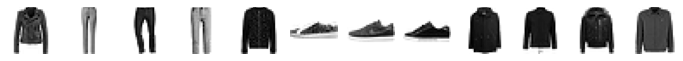

In [8]:
# coats, trousers, sneakers
class_inds = [4, 1, 7]
num_classes = len(class_inds)
class_size = 512
batch_size = 128

inds_by_class = [torch.where(img_data.targets == class_idx)[0][:class_size] 
                       for class_idx in class_inds]
data_inds = torch.flatten(torch.stack(inds_by_class).T)

AE_dataloader = DataLoader(Subset(img_data, data_inds),
                           batch_size=batch_size, shuffle=True)

print("Number of batches: ", len(AE_dataloader))

for X, y in AE_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break
    
plot_images(next(iter(AE_dataloader))[0], num=12)

# From images to EC through autoencoder

## Setup

In [16]:
EC_size = 1024
EC_sp = 0.1

In [36]:
def step(x, x0):
    return (x > x0).float()

# Straight-through estimator for binarization and backpropagation
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return step(x, 0.)

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)

# Binarization layer with gradients propagated backwards by STE
class Binarize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return STEFunction.apply(x)

In [37]:
# Middle binary layer represents EC
class Autoencoder(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, EC_size),
            nn.BatchNorm1d(EC_size),
            Binarize()
        )
        self.decoder = nn.Sequential(
            nn.Linear(EC_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(-1, (1, 28, 28))
        )
        
    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features)
        return x, features

In [19]:
# Loss function that enforces layer sparsity to be sp
class SparseLoss(nn.Module):
    def __init__(self, sp):
        super().__init__()
        self.sp = sp

    def forward(self, features):
        sp_hat = features.mean(1)
        kl_divergence = -self.sp * torch.log(sp_hat) - (1-self.sp) * torch.log(1-sp_hat)
        return kl_divergence.mean()

In [20]:
def AE_train(dataloader, model,
             err_criterion, sparse_criterion, sparse_strength,
             optimizer, num_epochs, print_epochs=5):
    
    size = len(dataloader.dataset)
    
    print(f"TRAINING -----------------------")
    model.train()
    
    for t in range(num_epochs):
        mean_err = 0.
        mean_sparse_loss = 0.
        mean_sp = 0.
        
        for X, _ in dataloader:
            X = X.to(device)
            pred, features = model(X)
            
            err = err_criterion(pred, X)
            sparse_loss = sparse_criterion(features)
            mean_err += err.item() * len(X)
            mean_sparse_loss += sparse_loss.item() * len(X)
            mean_sp += features.detach().mean().item() * len(X)

            loss = err + sparse_strength * sparse_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        mean_err = (mean_err / size)**0.5
        mean_sparse_loss /= size
        mean_sp /= size
        if (print_epochs > 0
            and ((t+1) % print_epochs == 0 or t == 0)):
            print(f"{t:>3d}"
                  f"   RMSE: {mean_err:>6f}"
                  f"   sp loss: {mean_sparse_loss:>6f}"
                  f"   sparsity: {mean_sp:>6f}")
        
    print(f"\nEVALUATING ---------------------")
    model.eval()
    
    mean_err = 0.
    mean_sp = 0.
    
    X_list = []
    y_list = []
    pred_list = []
    features_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, features = model(X)
            
            err = err_criterion(pred, X)
            mean_err += err.item() * len(X)
            mean_sp += features.detach().mean().item() * len(X)
            
            X_list.append(X.detach())
            y_list.append(y.detach())
            pred_list.append(pred.detach())
            features_list.append(features.detach())
            
    mean_err = (mean_err / size)**0.5
    mean_sp /= size
    print(f"RMSE: {mean_err:>5.4f}, sparsity: {mean_sp:>5.4f}")
    
    return torch.cat(X_list), torch.cat(y_list), torch.cat(pred_list), torch.cat(features_list)

## Evaluation

In [21]:
AE_model = Autoencoder(hidden_size=128).to(device)
print(AE_model)

AE_criterion = nn.MSELoss(reduction='mean')
sparse_criterion = SparseLoss(EC_sp)
sparse_strength = 1

AE_optimizer = torch.optim.Adam(AE_model.parameters(), lr=1e-3, weight_decay=1e-5)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Binarize()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Sigmoid()
    (5): Unflatten(dim=-1, unflattened_size=(1, 28, 28))
  )
)


In [22]:
num_epochs = 100
start_timer()
AE_X, AE_y, AE_pred, AE_features = AE_train(
    AE_dataloader, AE_model, AE_criterion,
    sparse_criterion, sparse_strength, AE_optimizer, num_epochs
)
end_timer_and_print()
print("Done!")

TRAINING -----------------------
  0   RMSE: 0.374066   sp loss: 0.688840   sparsity: 0.497176
  4   RMSE: 0.176751   sp loss: 0.660377   sparsity: 0.478903
  9   RMSE: 0.147019   sp loss: 0.625670   sparsity: 0.455358
 14   RMSE: 0.130706   sp loss: 0.588756   sparsity: 0.428726
 19   RMSE: 0.121815   sp loss: 0.554261   sparsity: 0.402161
 24   RMSE: 0.116137   sp loss: 0.519323   sparsity: 0.373305
 29   RMSE: 0.109996   sp loss: 0.483735   sparsity: 0.341568
 34   RMSE: 0.106571   sp loss: 0.451825   sparsity: 0.310511
 39   RMSE: 0.104225   sp loss: 0.421904   sparsity: 0.278378
 44   RMSE: 0.100611   sp loss: 0.395769   sparsity: 0.247368
 49   RMSE: 0.098843   sp loss: 0.372995   sparsity: 0.216517
 54   RMSE: 0.097688   sp loss: 0.356583   sparsity: 0.190781
 59   RMSE: 0.095436   sp loss: 0.343467   sparsity: 0.165980
 64   RMSE: 0.095189   sp loss: 0.336090   sparsity: 0.148408
 69   RMSE: 0.093070   sp loss: 0.330928   sparsity: 0.133479
 74   RMSE: 0.092177   sp loss: 0.328

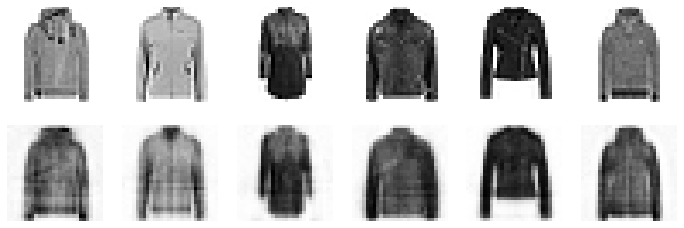

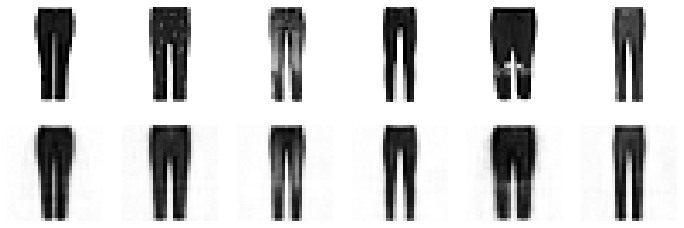

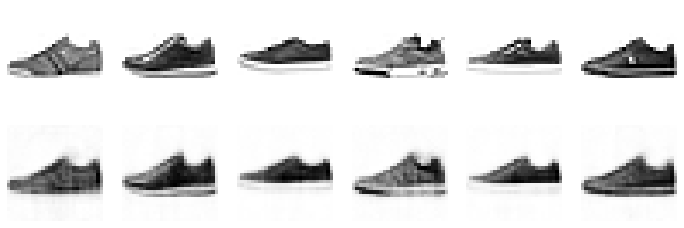

In [23]:
AE_inds_by_class = [torch.where(AE_y == class_idx)[0] for class_idx in class_inds]

X_by_class = [AE_X.index_select(0, inds) for inds in AE_inds_by_class]
pred_by_class = [AE_pred.index_select(0, inds) for inds in AE_inds_by_class]
features_by_class = [AE_features.index_select(0, inds) for inds in AE_inds_by_class]

for X, pred in zip(X_by_class, pred_by_class):
    plot_images((X, pred))

In [26]:
print("Correlations by class:")
print([pairwise_correlation(features) for features in features_by_class])

print("Cross-correlations:")
print([pairwise_correlation(features_by_class[i], features_by_class[j])
       for i, j in [(0,1), (0,2), (1,2)]])

Correlations by class:
[0.08845160901546478, 0.09853220731019974, 0.1541452556848526]
Cross-correlations:
[-0.01904207468032837, -0.013340339064598083, -0.028332138434052467]


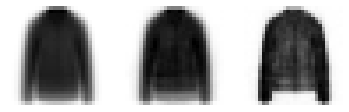

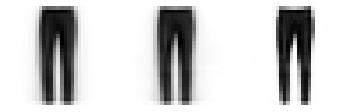

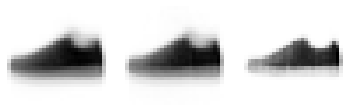

In [29]:
X_concepts = [X.mean(0) for X in X_by_class]
X_shape = X_concepts[0].shape
pred_concepts = [pred.mean(0) for pred in pred_by_class]

def sparse_binarize(vector, sp):
    return (vector >= vector.quantile(1-sp)).float()

features_means = [sparse_binarize(features.mean(0), EC_sp) for features in features_by_class]

AE_model.eval()
with torch.no_grad():
    features_concepts = [AE_model.decoder(features.unsqueeze(0)).squeeze(0)
                         for features in features_means]
    
for X, pred, features in zip(X_concepts, pred_concepts, features_concepts):
    plot_images((X, pred, features), size=6)

In [31]:
torch.save({
    'model_state_dict': AE_model.state_dict(),
    'class_inds': class_inds,
    'X_by_class': X_by_class,
    'pred_by_class': pred_by_class,
    'features_by_class': features_by_class,
    'X_concepts': X_concepts,
    'pred_concepts': pred_concepts,
    'features_concepts': features_concepts
}, f"results/AE.pt")

# From EC to CA3 through random connectivity

## Setup

In [33]:
DG_size = EC_size * 8
CA3_size = EC_size * 2

print(f"Number of neurons")
print(f"EC: {EC_size},  DG: {DG_size},  CA3: {CA3_size}")

DG_conn = 0.2
PP_conn = 0.2
MF_conn = 0.001

DG_per_post = round(DG_conn * EC_size)
PP_per_post = round(PP_conn * EC_size)
MF_per_post = round(MF_conn * DG_size)

print(f"\nNumber of inputs per postsynaptic neuron")
print(f"DG: {DG_per_post},  PP: {PP_per_post},  MF: {MF_per_post}")

DG_sp = 0.005
PP_sp = 0.2
MF_sp = 0.02

DG_active = round(DG_sp * DG_size)
PP_active = round(PP_sp * CA3_size)
MF_active = round(MF_sp * CA3_size)

print(f"\nNumber of active neurons")
print(f"DG: {DG_active},  PP: {PP_active},  MF: {MF_active}")

Number of neurons
EC: 1024,  DG: 8192,  CA3: 2048

Number of inputs per postsynaptic neuron
DG: 205,  PP: 205,  MF: 8

Number of active neurons
DG: 41,  PP: 410,  MF: 41


In [34]:
# Random connectivities stored as sparse matrices
def create_synapses(pre_size, post_size, inputs_per_post):
    data = np.ones(post_size * inputs_per_post, dtype=int)
    indices = np.concatenate([np.random.choice(pre_size, inputs_per_post, replace=False)
                              for _ in range(post_size)])
    indptr = np.arange(post_size+1) * inputs_per_post
    return csr_matrix((data, indices, indptr), shape=(post_size, pre_size))

DG_synapses = create_synapses(EC_size, DG_size, DG_per_post)
MF_synapses = create_synapses(DG_size, CA3_size, MF_per_post)
PP_synapses = create_synapses(EC_size, CA3_size, PP_per_post)

In [40]:
# k-winners-take-all implicitly sets an activity threshold
def kWTA(inputs, k):
    tiebreaker = np.random.rand(inputs.size)
    inds = np.lexsort((tiebreaker, inputs))
    output = np.zeros_like(inputs)
    np.put(output, inds[-k:], 1)
    return output

# Apply connectivity matrix then apply kWTA
def feedforward_WTA(pre_patterns, synapses, post_active):
    post_inputs = synapses.dot(pre_patterns.T).T
    return np.apply_along_axis(kWTA, 1, post_inputs, k=post_active)

## Evaluation 

In [41]:
EC_patterns = [features.cpu().numpy().astype(int)
               for features in features_by_class]

DG_patterns = [feedforward_WTA(patterns, DG_synapses, DG_active)
               for patterns in EC_patterns]
MF_patterns = [feedforward_WTA(patterns, MF_synapses, MF_active)
               for patterns in DG_patterns]
PP_patterns = [feedforward_WTA(patterns, PP_synapses, PP_active)
               for patterns in EC_patterns]

In [42]:
print("EC sparsity:")
print([patterns.mean() for patterns in EC_patterns])
print("\nDG sparsity:")
print([patterns.mean() for patterns in DG_patterns])
print("\nMF sparsity:")
print([patterns.mean() for patterns in MF_patterns])
print("\nPP sparsity:")
print([patterns.mean() for patterns in PP_patterns])

EC sparsity:
[0.10310935974121094, 0.09760284423828125, 0.09601020812988281]

DG sparsity:
[0.0050048828125, 0.0050048828125, 0.0050048828125]

MF sparsity:
[0.02001953125, 0.02001953125, 0.02001953125]

PP sparsity:
[0.2001953125, 0.2001953125, 0.2001953125]


In [43]:
print("EC correlation:")
print([pairwise_correlation(patterns) for patterns in EC_patterns])
print("\nDG correlation:")
print([pairwise_correlation(patterns) for patterns in DG_patterns])
print("\nMF correlation:")
print([pairwise_correlation(patterns) for patterns in MF_patterns])
print("\nPP correlation:")
print([pairwise_correlation(patterns) for patterns in PP_patterns])

EC correlation:
[0.08888765424489975, 0.0986236110329628, 0.15416273474693298]

DG correlation:
[0.008346157148480415, 0.009202148765325546, 0.014614111743867397]

MF correlation:
[0.0043519833125174046, 0.004456017166376114, 0.007672607433050871]

PP correlation:
[0.046025507152080536, 0.053332775831222534, 0.08144451677799225]


In [44]:
print("\nMF cross-correlation:")
print([pairwise_correlation(MF_patterns[i], MF_patterns[j])
       for i, j in [(0,1), (0,2), (1,2)]])
print("\nPP cross-correlation:")
print([pairwise_correlation(PP_patterns[i], PP_patterns[j])
       for i, j in [(0,1), (0,2), (1,2)]])


MF cross-correlation:
[-0.00026881525991484523, -0.0006391561473719776, -0.0007840070757083595]

PP cross-correlation:
[-0.0080377496778965, -0.007017499767243862, -0.01360563188791275]


In [45]:
# Category is identical to concept
# PP categories are represented by the most active neurons up to PP sparsity
def category_WTA(patterns, num_active):
    return kWTA(patterns.sum(0), k=num_active)

cat_patterns = [category_WTA(patterns, PP_active) for patterns in PP_patterns]
print("category sparsity:")
print([patterns.mean() for patterns in cat_patterns])

category sparsity:
[0.2001953125, 0.2001953125, 0.2001953125]


In [48]:
# We save patterns as packed binary arrays
def save_patterns_binary(pattern_list, file):
    binfile = open(file, 'w')
    for patterns in pattern_list:
        bindata = np.packbits(patterns)
        bindata.tofile(binfile)
    binfile.close()

In [49]:
# Directory name is used by the Hopfield simulation to recognize pattern statistics
pattern_dir = f"results/" \
              f"N{CA3_size}-p{num_classes}-s{class_size}" \
              f"-a{str(MF_sp).split('0.')[1]}-{str(PP_sp).split('0.')[1]}"
print(pattern_dir)
if not os.path.exists(pattern_dir):
    os.mkdir(pattern_dir)
save_patterns_binary(MF_patterns, f"{pattern_dir}/x_sparse.dat")
save_patterns_binary(PP_patterns, f"{pattern_dir}/x_dense.dat")
save_patterns_binary(cat_patterns, f"{pattern_dir}/x_cat.dat")

results/N2048-p3-s512-a02-2


# From CA3 to EC through feedforward network 

## Setup

In [50]:
sparse_patterns = torch.as_tensor(np.concatenate(MF_patterns), dtype=torch.float)
dense_patterns = torch.as_tensor(np.concatenate(PP_patterns), dtype=torch.float)
AE_features = torch.cat(features_by_class).cpu()

class FeedforwardDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        if len(X) != len(Y):
            raise Exception("input and output patterns must have same length")

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        X_sample = self.X[idx]
        Y_sample = self.Y[idx]
        
        if self.transform:
            X_sample = self.transform(X_sample)
            Y_sample = self.transform(Y_sample)
        
        return (X_sample, Y_sample)
    
sparse_data = FeedforwardDataset(sparse_patterns, AE_features)
dense_data = FeedforwardDataset(dense_patterns, AE_features)

batch_size = 128
FF_dataloaders = (DataLoader(sparse_data, batch_size=batch_size, shuffle=True),
                  DataLoader(dense_data, batch_size=batch_size, shuffle=True))

print("Number of batches: ", len(FF_dataloaders[0]))

for X, Y in FF_dataloaders[0]:
    print("Shape of X: ", X.shape, X.dtype)
    print("Shape of Y: ", Y.shape, Y.dtype)
    break

Number of batches:  12
Shape of X:  torch.Size([128, 2048]) torch.float32
Shape of Y:  torch.Size([128, 1024]) torch.float32


In [51]:
class Feedforward(nn.Module):
    def __init__(self, hidden_size=2*CA3_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.feedforward = nn.Sequential(
            nn.Linear(CA3_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, EC_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.feedforward(x)

In [58]:
def FF_train(dataloaders, model, err_criterion, optimizer,
             num_epochs, print_epochs=5):
    
    size = len(dataloaders[0].dataset)
    
    print(f"TRAINING -----------------------")
    model.train()
    
    for t in range(num_epochs):
        mean_loss = np.array([0., 0.], dtype=float)
        mean_overlap = np.array([0., 0.], dtype=float)
        mean_sparsity = np.array([0., 0.], dtype=float)
    
        for tt, dataloader in enumerate(dataloaders):
            for X, Y in dataloader:
                X, Y = X.to(device), Y.to(device)
                output = model(X)

                loss = err_criterion(Y, output)
                mean_loss[tt] += loss.item() * len(Y)
                pred = output.detach()
                with torch.no_grad():
                    overlaps = (Y * pred).sum(1) / Y.sum(1)
                    mean_overlap[tt] += overlaps.sum().item()
                    sparsities = pred.mean(1)
                    mean_sparsity[tt] += sparsities.sum().item()

                loss.backward()
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
        
        mean_loss = (mean_loss / size)**0.5
        mean_overlap = mean_overlap / size
        mean_sparsity = mean_sparsity / size
        if (print_epochs > 0
            and ((t+1) % print_epochs == 0 or t == 0)):
            print(f"{t:>3d}"
                  f"   RMSE: {mean_loss[0]:>5.4f} {mean_loss[1]:>5.4f}"
                  f"   overlap: {mean_overlap[0]:>5.4f} {mean_overlap[1]:>5.4f}"
                  f"   sparsity: {mean_sparsity[0]:>4.3f} {mean_sparsity[1]:>4.3f}")

    print(f"\nEVALUATING ---------------------")
    model.eval()

    Y_list = [[], []]
    pred_list = [[], []]
    
    mean_overlap = np.array([0., 0.], dtype=float)
    mean_sparsity = np.array([0., 0.], dtype=float)
    
    with torch.no_grad():
        for tt, dataloader in enumerate(dataloaders):
            for X, Y in dataloader:
                X, Y = X.to(device), Y.to(device)
                output = model(X)
                pred = output.detach()

                overlaps = (Y * pred).sum(1) / Y.sum(1)
                mean_overlap[tt] += overlaps.sum().item()
                sparsities = pred.mean(1)
                mean_sparsity[tt] += sparsities.sum().item()
        
            Y_list[tt].append(Y.detach())
            pred_list[tt].append(pred)   
            
    mean_overlap = mean_overlap / size
    mean_sparsity = mean_sparsity / size
    print(f"overlap: {mean_overlap[0]:>5.4f} {mean_overlap[1]:>5.4f},  ", end='')
    print(f"sparsity: {mean_sparsity[0]:>4.3f} {mean_sparsity[1]:>4.3f}")
    
    Y_list = [torch.cat(Y) for Y in Y_list]
    pred_list = [torch.cat(pred) for pred in pred_list]

    return Y_list, pred_list

## Evaluation

In [59]:
FF_model = Feedforward(hidden_size=2*CA3_size).to(device)
print(FF_model)

FF_criterion = nn.MSELoss(reduction='mean')
FF_optimizer = torch.optim.Adam(FF_model.parameters(), lr=1e-4, weight_decay=1e-5)

Feedforward(
  (feedforward): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=1024, bias=True)
    (4): Sigmoid()
  )
)


In [60]:
num_epochs = 100
start_timer()
FF_Y, FF_pred = FF_train(
    FF_dataloaders, FF_model, FF_criterion, FF_optimizer, num_epochs
)
end_timer_and_print()
print("Done!")

TRAINING -----------------------
  0   RMSE: 0.3901 0.2986   overlap: 0.3149 0.1252   sparsity: 0.313 0.112
  4   RMSE: 0.2765 0.2461   overlap: 0.2037 0.3585   sparsity: 0.112 0.128
  9   RMSE: 0.2329 0.1982   overlap: 0.3815 0.5469   sparsity: 0.125 0.140
 14   RMSE: 0.1909 0.1645   overlap: 0.5325 0.6492   sparsity: 0.128 0.137
 19   RMSE: 0.1573 0.1385   overlap: 0.6381 0.7146   sparsity: 0.127 0.132
 24   RMSE: 0.1309 0.1181   overlap: 0.7113 0.7612   sparsity: 0.126 0.127
 29   RMSE: 0.1110 0.1022   overlap: 0.7603 0.7953   sparsity: 0.123 0.123
 34   RMSE: 0.0958 0.0897   overlap: 0.7956 0.8203   sparsity: 0.121 0.120
 39   RMSE: 0.0848 0.0801   overlap: 0.8201 0.8398   sparsity: 0.119 0.118
 44   RMSE: 0.0764 0.0726   overlap: 0.8386 0.8546   sparsity: 0.117 0.116
 49   RMSE: 0.0704 0.0674   overlap: 0.8514 0.8650   sparsity: 0.116 0.115
 54   RMSE: 0.0654 0.0628   overlap: 0.8623 0.8737   sparsity: 0.115 0.113
 59   RMSE: 0.0619 0.0597   overlap: 0.8704 0.8796   sparsity: 0.11

In [61]:
torch.save({
    'model_state_dict': FF_model.state_dict()
}, f"results/FF.pt")